# 회귀실습 - 캐글 주택가격 : 고급회귀 기법
* [캐글 데이터셋](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)
* 평가 포인트  : RSME(Residual Sum of Squares)를 최소화하는 계수 찾기
* 데이터셋 설명 :

미국 아이오아주의 에임스 지방의 주택가격이 결정이 될때 가격을 결정하는 요소가 단지 지하실의 천장의 높이나 화려하고 깨끗한 하얀색의 담장이 주는 환상보다 더한 변수들이 있다는 것을 보여주는 좋은 데이터셋이며 해당 데이터셋은 보스톤 주택가격 데이터셋보다 더 확장된 버전이라고 할수 있다.
* 가격이 비싼 주택일수록 예측 결과 오류가 전체 오류에 미치는 비중이 높으로 이것을 상쇄하기 위해 오류값을 로그 변환한 RMSLE을 이용

## 데이터 사전 처리 (Preprocessing)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False
f_path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=f_path).get_name()
rc('font', family=font_name)

In [2]:
house_df_org = pd.read_csv("../../08.Kaggle_Dacon/data/house-prices-advanced-regression-techniques/house_price.csv")

In [3]:
house_df = house_df_org.copy()

In [4]:
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [5]:
# 데이터세트의 전체 크기 및 컬럼의 타입
display(house_df.shape, house_df.dtypes.value_counts())

(1460, 81)

object     43
int64      35
float64     3
dtype: int64

In [6]:
# 널인 피처의 갯수
display(house_df.isnull().sum())

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [7]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [8]:
isnullseries = house_df.isnull().sum()
isnullseries = isnullseries[ isnullseries > 0].sort_values(ascending = False)

In [9]:
isnullseries.keys

<bound method Series.keys of PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64>

***널값이 많은 상위 4개 피처 - PoolQC, MiscFeature, Alley, Fence - 는 삭제 할것.***

#### 회귀모델 적용전 타겟 값의 분포도 확인

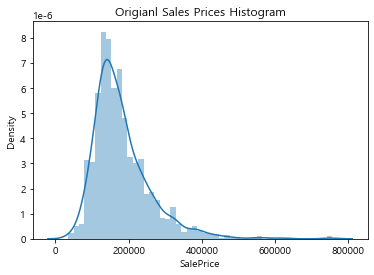

In [10]:
plt.title("Origianl Sales Prices Histogram")
sns.distplot(house_df.SalePrice)

* 정규분포가 아닌 왼쪽으로 치우쳐진 행태의 분포를 보이므로 리를 로그변환을 통해 정규분포에 가깝게 변환해보자.

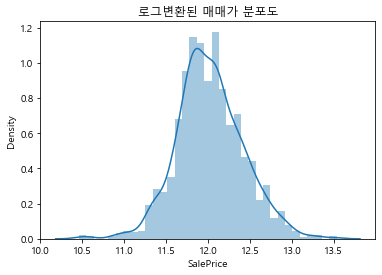

In [11]:
plt.title("로그변환된 매매가 분포도")
log_salesprice = np.log1p(house_df['SalePrice'])
sns.distplot(log_salesprice)

### 결측치 처리 및 로그변환
* 널값인 상위 4개는 삭제처리 
* id컬럼 삭제 처리 
* LogFrontage는 널값은 평균값으로 대체
* 나머지 널값 갯수가 많지 않는 컬럼은 평균값으로 대체

In [12]:
# Sale Price로그 변환
origianl_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# 삭제하고자 하는 컬럼
nullCol = ['MiscFeature','Alley','Fence','FireplaceQu', 'Id']
house_df.drop(labels = nullCol,axis = 1, inplace = True, errors = 'ignore') # 널인 컬럼 삭제

# 삭제하지 않은 숫자형 널컬럼은 평균값으로 대체
house_df.fillna(house_df.mean(), inplace = True)

In [13]:
house_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,NaN,0,2,2008,WD,Normal,12.247699
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,NaN,0,5,2007,WD,Normal,12.109016
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,NaN,0,9,2008,WD,Normal,12.317171
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,NaN,0,2,2006,WD,Abnorml,11.849405
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,NaN,0,12,2008,WD,Normal,12.429220


In [14]:
# 널값이 있는 피처명과 타입을 추출
null_columns_cnt = house_df.isnull().sum()[house_df.isnull().sum() > 0 ]
null_columns_cnt

print("## Null 피처의 Type :\ n", house_df.dtypes[null_columns_cnt.index])

## Null 피처의 Type :\ n MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
PoolQC          object
dtype: object


In [15]:
# 원-핫 인코딩
print('get_dummies() 수행전 데이터 Shape :', house_df.shape)

house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행후 데이터 Shape :', house_df_ohe.shape)


null_columns_cnt = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0 ]
print("## Null피처의 Type : \n", house_df_ohe.dtypes[null_columns_cnt.index])

get_dummies() 수행전 데이터 Shape : (1460, 76)
get_dummies() 수행후 데이터 Shape : (1460, 274)
## Null피처의 Type : 
 Series([], dtype: object)


## 선형회귀 모델 학습 / 예측 / 평가

In [16]:
from sklearn.metrics import mean_squared_error
def get_rmse(model):
    """
    Description : 각각의 모델에 대한 RMSE
    """
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, "로그변환된 RMSE : ", np.round(rmse, 3))
    return rmse

def get_rmses(models):
    """
    모델별로 처리 
    """
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [17]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop(['SalePrice'], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = .2, random_state = 156)

# LinearRegression, Ridge, Lasso학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
rmse = get_rmses(models)

LinearRegression 로그변환된 RMSE :  0.131
Ridge 로그변환된 RMSE :  0.128
Lasso 로그변환된 RMSE :  0.176


In [18]:
def get_top_bottom(model, n = 10):
    # coef_속성을 기반으로 Series객체를 생성, index는 컬럼명
    coef = pd.Series(model.coef_, index = X_features.columns)
    
    # + 상위 10개, - 하위 10개의 회귀계수를 추출해 반환
    coef_high = coef.sort_values(ascending = False).head(n)
    coef_low = coef.sort_values(ascending= False).tail(n)
    return coef_high, coef_low

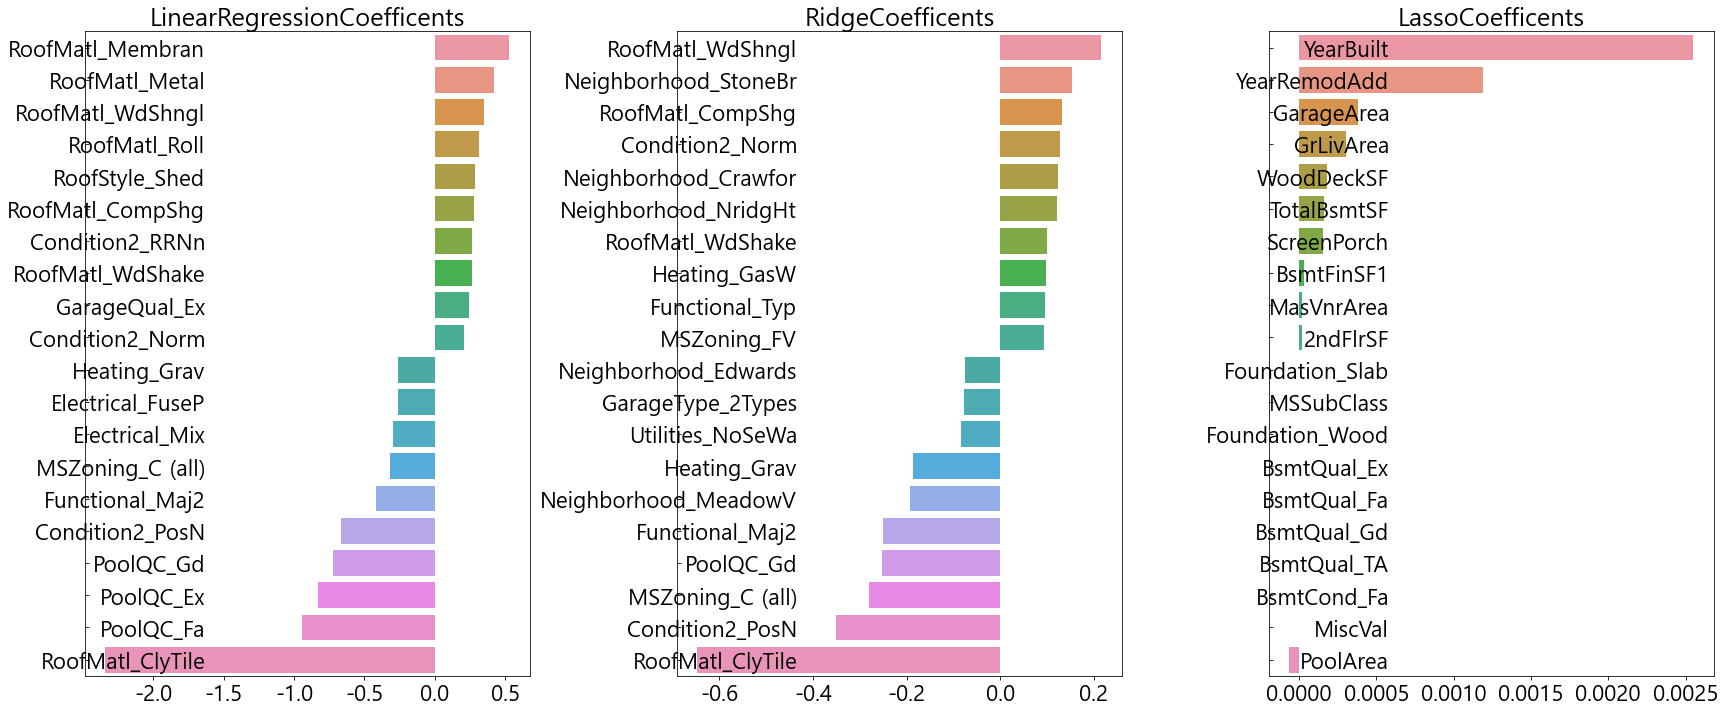

In [19]:
def visualize_coefficient(models):
    """
    모델별 회귀계수 시각화
    """
    fig, axs = plt.subplots(figsize = (24, 10), nrows = 1, ncols =3)
    fig.tight_layout()
    
    # 입력인자로 받은 list객체인 모델에서 루프를 돌면서 model를 추출해 회귀 계수 시각화
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합
        coef_high, coef_low = get_top_bottom(model)
        coef_concat = pd.concat([coef_high, coef_low])
        
        # ax subplot에 barchart로 표현, 한 화면에 표현하기 위해 tick label위치와 font크기 조정
        axs[i_num].set_title(model.__class__.__name__+ 'Coefficents', size = 25)
        # 그래프의 눈금에 대한 설정
        # axis='both' 혹은 'y'  - Y축만 적용
        # directions = 'in' 틱의 방향을 안쪽으로 적용
        # pad = 120 틱과 레이블의 거리 120
        axs[i_num].tick_params(axis = 'y', direction = 'in', pad = -120)
        
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x = coef_concat.values, y = coef_concat.index, ax = axs[i_num])
    plt.tight_layout()

# 앞 예제엇 학습한 lr_ref, ridge_reg, lasso_reg모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

### 학습과 테스트 데이터세트를 분할하지 않고, cross_val_score()를 이용해 교차검증
* 사용 데이터 셋은 X_features와 y_target이용

In [20]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_socre()수행. 모델별 CV RMSE값과 평균 RMSE출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, cv = 5, scoring = 'neg_mean_squared_error'))
        
        rmse_avg = np.mean(rmse_list)
        
        print("\n{0} CV RMSE 값 리스트 : {1}".format(model.__class__.__name__, np.round(rmse_list, 3)))
        print("\n{0} CV 평균 RMSE 값 : {1}".format(model.__class__.__name__, np.round(rmse_avg, 3)))
        
# 앞 예제에서 학습한 lr_regm ridge_reg, lasso_reg모델의 CV RMSE 값 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트 : [0.136 0.164 0.167 0.111 0.2  ]

LinearRegression CV 평균 RMSE 값 : 0.156

Ridge CV RMSE 값 리스트 : [0.116 0.154 0.142 0.117 0.19 ]

Ridge CV 평균 RMSE 값 : 0.144

Lasso CV RMSE 값 리스트 : [0.161 0.204 0.177 0.181 0.265]

Lasso CV 평균 RMSE 값 : 0.198


In [21]:
help(cross_val_score)

Help on function cross_val_score in module sklearn.model_selection._validation:

cross_val_score(estimator, X, y=None, *, groups=None, scoring=None, cv=None, n_jobs=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', error_score=nan)
    Evaluate a score by cross-validation
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    estimator : estimator object implementing 'fit'
        The object to use to fit the data.
    
    X : array-like of shape (n_samples, n_features)
        The data to fit. Can be for example a list, or an array.
    
    y : array-like of shape (n_samples,) or (n_samples, n_outputs),             default=None
        The target variable to try to predict in the case of
        supervised learning.
    
    groups : array-like of shape (n_samples,), default=None
        Group labels for the samples used while splitting the dataset into
        train/test set. Only used in conjunction with a "Group" :term:`cv`

### 모델별로 하이퍼 파라미터 최적화 진행
* GridSearchCV클래스 이용

In [22]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    """
    GridSearchCV를 이용한 각 모델의 하이퍼 파라미터 튜닝 및 
    가장 최적의 estimator를 리턴함.
    """
    gridmodel = GridSearchCV(model, param_grid = params, scoring = 'neg_mean_squared_error', cv = 5)
    gridmodel.fit(X_features, y_target)
    rmse = np.sqrt(-1 * gridmodel.best_score_)
    
    print("{0} 5 CV시 최적 평균 RMSE값 : {1}, 최적 alpha  {2}".format(model.__class__.__name__, np.round(rmse, 4), gridmodel.best_params_))
    return gridmodel.best_estimator_ 
    
ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV시 최적 평균 RMSE값 : 0.1417, 최적 alpha  {'alpha': 10}
Lasso 5 CV시 최적 평균 RMSE값 : 0.142, 최적 alpha  {'alpha': 0.001}


Lasso(alpha=0.001)

In [23]:
help(GridSearchCV)

Help on class GridSearchCV in module sklearn.model_selection._search:

class GridSearchCV(BaseSearchCV)
 |  GridSearchCV(estimator, param_grid, *, scoring=None, n_jobs=None, iid='deprecated', refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)
 |  
 |  Exhaustive search over specified parameter values for an estimator.
 |  
 |  Important members are fit, predict.
 |  
 |  GridSearchCV implements a "fit" and a "score" method.
 |  It also implements "predict", "predict_proba", "decision_function",
 |  "transform" and "inverse_transform" if they are implemented in the
 |  estimator used.
 |  
 |  The parameters of the estimator used to apply these methods are optimized
 |  by cross-validated grid-search over a parameter grid.
 |  
 |  Read more in the :ref:`User Guide <grid_search>`.
 |  
 |  Parameters
 |  ----------
 |  estimator : estimator object.
 |      This is assumed to implement the scikit-learn estimator interface.
 |      Either e

LinearRegression 로그변환된 RMSE :  0.131
Ridge 로그변환된 RMSE :  0.124
Lasso 로그변환된 RMSE :  0.12


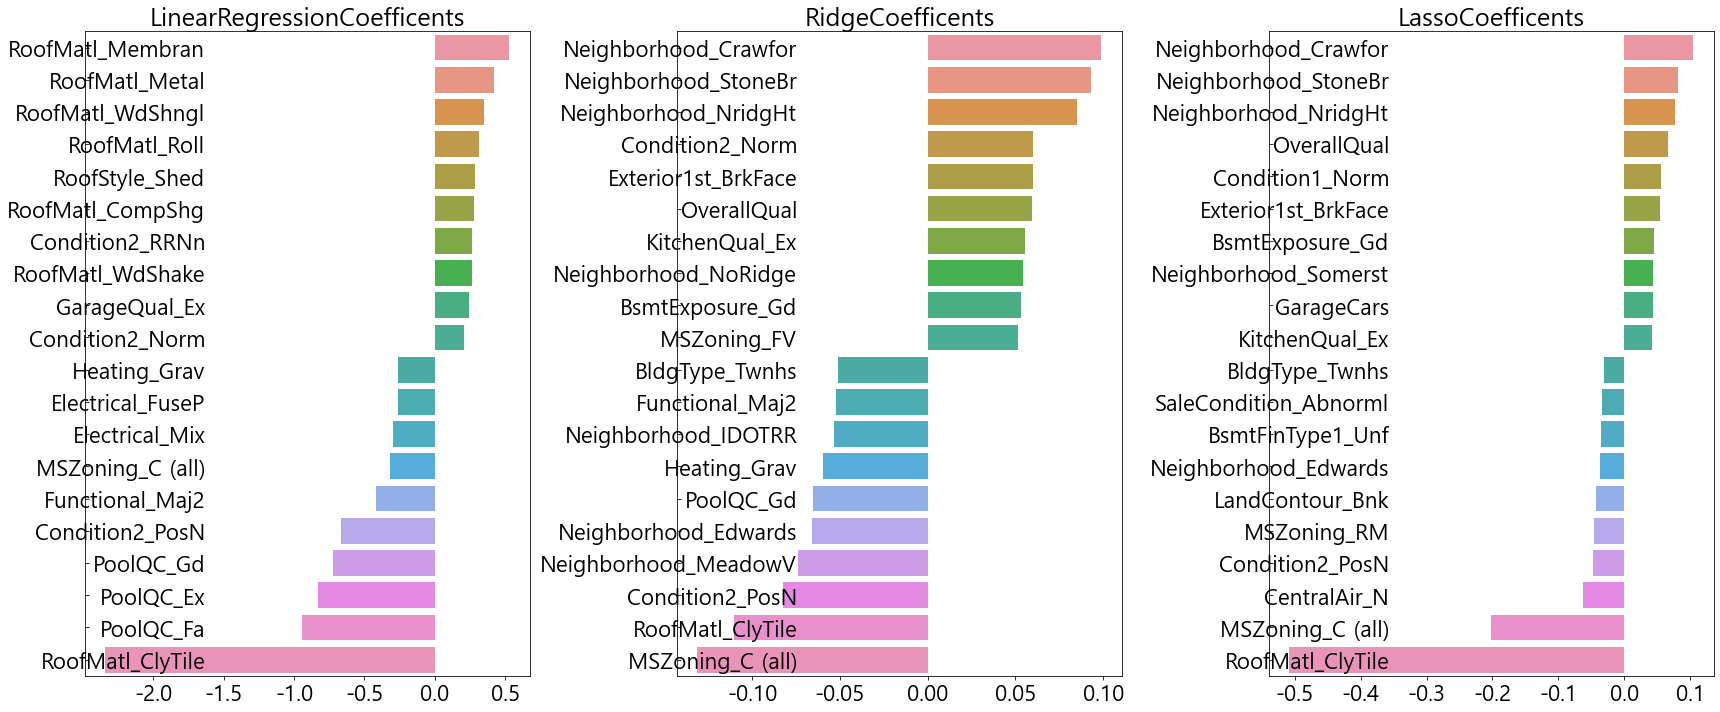

In [24]:
# 앞의 최적화 alpha값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha = 10)
ridge_reg.fit(X_train, y_train)


lasso_reg = Lasso(alpha = 0.001)
lasso_reg.fit(X_train, y_train)

#모든 모델의 RSME출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
visualize_coefficient(models)

### 모든 숫자형 피처의 분포도 확인
- scipy stats모듈의 **skew()함수**를 이용해 칼럼의 데이터세트의 왜곡된 정도 추출
- 원-핫 인코딩이 적용된 데이터프레임이 아닌 데이터프레임이 대상이어야 함.

In [25]:
from scipy.stats import skew

# feature_index가 아닌 숫자형 피처의 칼럼 index객체 추출
features_index = house_df.dtypes[house_df.dtypes != 'object'].index

#house_df에 칼럼 index를 []로 입력하면 해당하는 칼럼 데이터 세트 반환.apply lambda로 skew() 호출 
skew_features = house_df[features_index].apply(lambda x:skew(x))
skew_features

# skew()왜곡정도가 1이상인 컬럼만 추출
skew_features_top = skew_features[skew_features > 1]

# type(skew_features_top) # 시리즈 
skew_features_top.sort_values(ascending = False)

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64

In [26]:
#왜곡정도가 높은 피처를 로그 변환
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [27]:
# 왜곡정도가 높은 피처를 로그 변환했으므몰 다시 원-핫 인코딩을 적용하고 피처/타깃 데이터세트 생성
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop(['SalePrice'], axis =1, inplace = False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = .2, random_state = 156)

ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV시 최적 평균 RMSE값 : 0.1275, 최적 alpha  {'alpha': 10}
Lasso 5 CV시 최적 평균 RMSE값 : 0.1252, 최적 alpha  {'alpha': 0.001}


Lasso(alpha=0.001)

LinearRegression 로그변환된 RMSE :  0.128
Ridge 로그변환된 RMSE :  0.123
Lasso 로그변환된 RMSE :  0.119


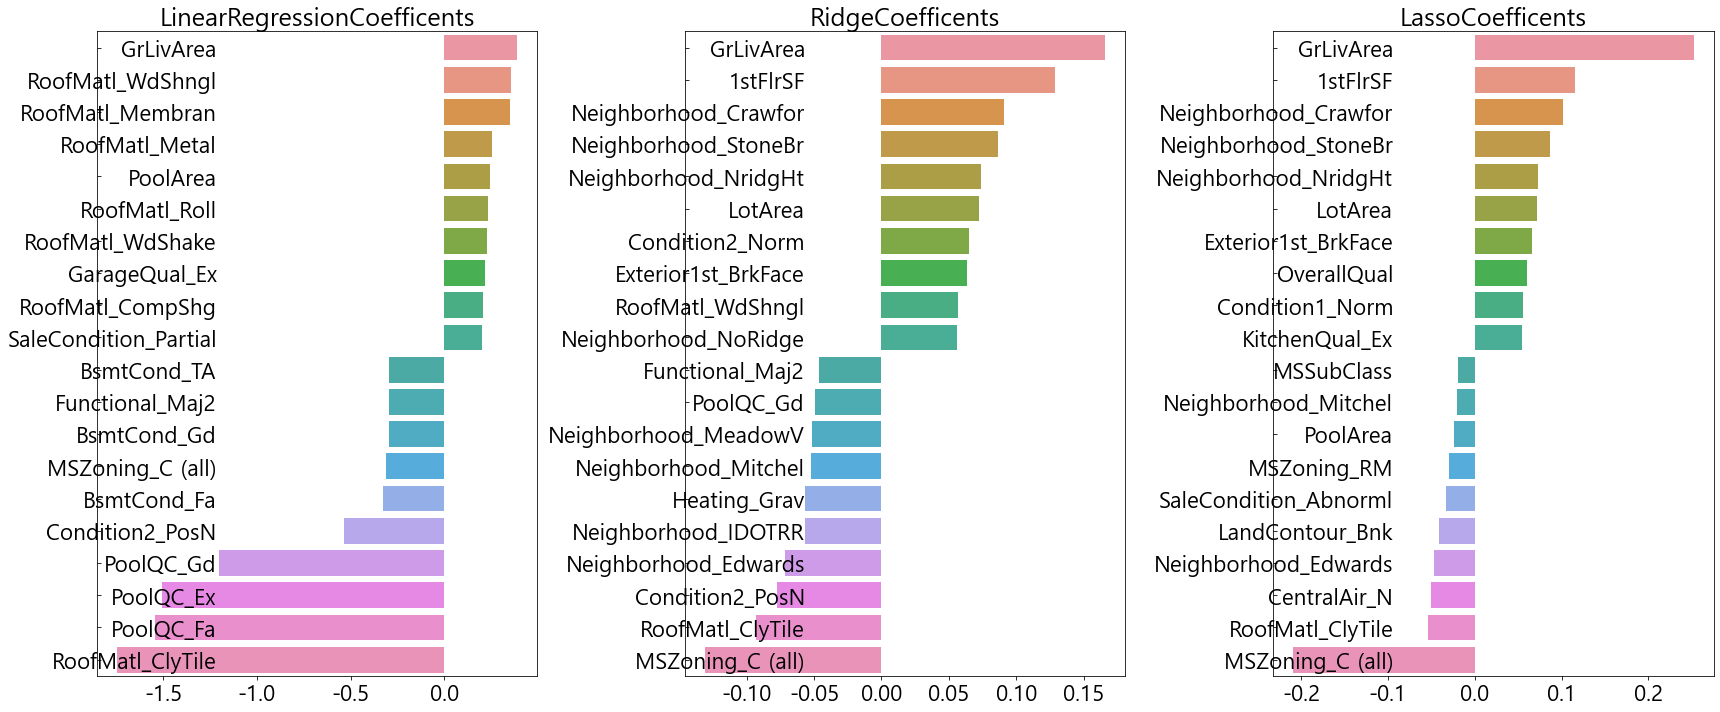

In [28]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

### 이상치 데이터 
* 특히 회귀계수가 높은 피처, 즉 예측에 많은 영향을 미치는 중요 피처의 이상치 데이터를 처리가 중요함.
* 세 회귀모델중에 공통적으로 가장 회귀계수를 가지는 GrLiveArea피처의 데이터 분포도 확인

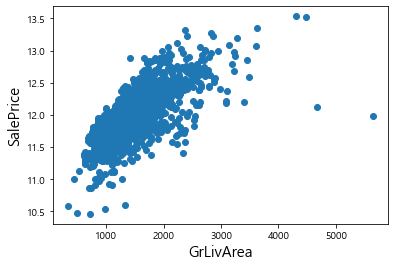

In [29]:
plt.scatter(x = house_df_org['GrLivArea'], y = house_df['SalePrice'])
plt.ylabel("SalePrice", fontsize =15)
plt.xlabel("GrLivArea", fontsize = 15)
plt.show()

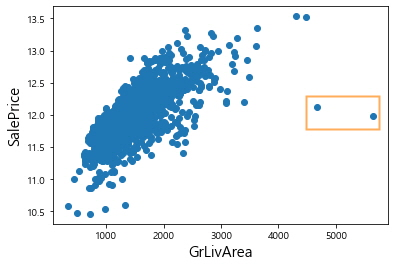

In [30]:
from IPython.display import Image
Image("../../img/아웃라이어.png")

In [31]:
# 이상치 데이터의 삭제
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] > np.log1p(50000)

outlier_index = house_df_ohe[cond1 & cond2].index

print("이상치 레코드 index : ", outlier_index.values)
print("이상치 삭제전 house_df_ohe.shape  : ", house_df_ohe.shape)

# DataFrame의 인덱스를 이용해 이상치 레코드 삭제 
house_df_ohe.drop(index = outlier_index, axis = 0, inplace = True)
print("이상치 삭제후 house_df_ohe.shape : ", house_df_ohe.shape)

이상치 레코드 index :  [ 523  691 1182 1298]
이상치 삭제전 house_df_ohe.shape  :  (1460, 274)
이상치 삭제후 house_df_ohe.shape :  (1456, 274)


In [32]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis = 1, inplace = False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = .2, random_state = 156)

ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV시 최적 평균 RMSE값 : 0.1125, 최적 alpha  {'alpha': 8}
Lasso 5 CV시 최적 평균 RMSE값 : 0.1121, 최적 alpha  {'alpha': 0.001}


Lasso(alpha=0.001)

* 이상치를 찾는것은 쉽진 않지만, 회귀에 중요한 영향을 미치는 피처를 위주로 이상치 데이터를 찾으려는 노력이 중요함.

LinearRegression 로그변환된 RMSE :  0.133
Ridge 로그변환된 RMSE :  0.117
Lasso 로그변환된 RMSE :  0.116


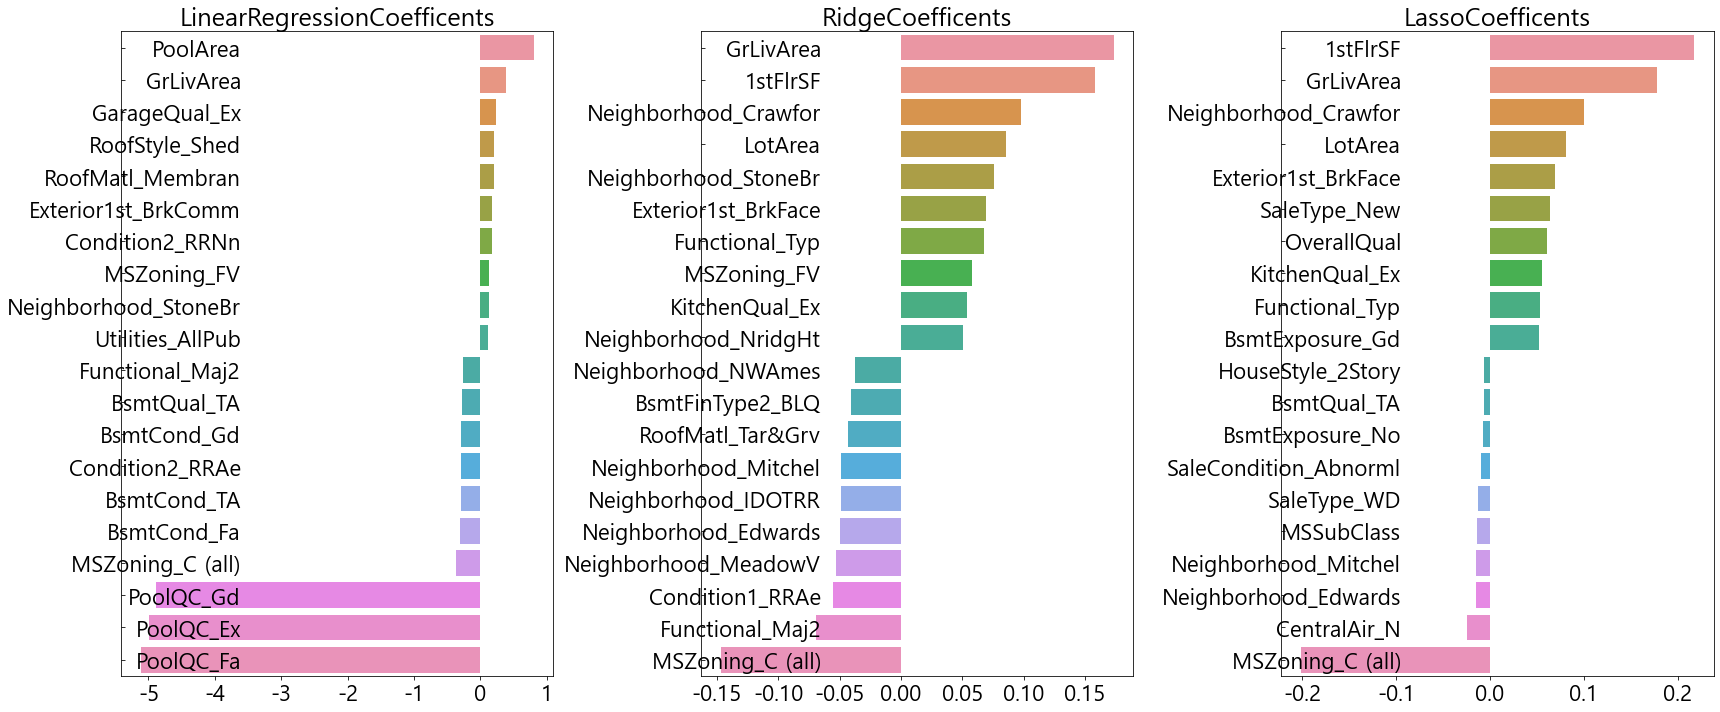

In [33]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

### 회귀 트리 모델 학습 / 예측 / 평가

* XGBoostRegressor를 이용한 회귀 트리 모델

In [34]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators': [1000]}
xgb_reg = XGBRegressor(n_estimators = xgb_params,learning_rate = 0.05, colsample_bytree = 0.5, subsample = .8)
xgb = print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV시 최적 평균 RMSE값 : 0.1192, 최적 alpha  {'n_estimators': 1000}


In [35]:
help(XGBRegressor)

Help on class XGBRegressor in module xgboost.sklearn:

class XGBRegressor(XGBModel, sklearn.base.RegressorMixin)
 |  XGBRegressor(*, objective='reg:squarederror', **kwargs)
 |  
 |  Implementation of the scikit-learn API for XGBoost regression.
 |  
 |  
 |  Parameters
 |  ----------
 |  
 |      n_estimators : int
 |          Number of gradient boosted trees.  Equivalent to number of boosting
 |          rounds.
 |  
 |      max_depth : int
 |          Maximum tree depth for base learners.
 |      learning_rate : float
 |          Boosting learning rate (xgb's "eta")
 |      verbosity : int
 |          The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
 |      objective : string or callable
 |          Specify the learning task and the corresponding learning objective or
 |          a custom objective function to be used (see note below).
 |      booster: string
 |          Specify which booster to use: gbtree, gblinear or dart.
 |      tree_method: string
 |          S

* LGBMRegressor을 이용한 회귀 트리 모델

In [36]:
from lightgbm import LGBMRegressor

# subsample : 학습셋에서의 샘플링 비율
# colsample_bytree : 
lgbm_params = {'n_estimators': [1000]}
lgbm_reg = LGBMRegressor(n_estimators = lgbm_params, learning_rate = .05,  num_leaves = 4,subsample =.6, colsample_bytree = .4, reg_lambda = 10, n_jobs = -1)
lgbm = print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV시 최적 평균 RMSE값 : 0.1158, 최적 alpha  {'n_estimators': 1000}


In [37]:
help(LGBMRegressor)

Help on class LGBMRegressor in module lightgbm.sklearn:

class LGBMRegressor(LGBMModel, sklearn.base.RegressorMixin)
 |  LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=-1, silent=True, importance_type='split', **kwargs)
 |  
 |  LightGBM regressor.
 |  
 |  Method resolution order:
 |      LGBMRegressor
 |      LGBMModel
 |      sklearn.base.BaseEstimator
 |      sklearn.base.RegressorMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  fit(self, X, y, sample_weight=None, init_score=None, eval_set=None, eval_names=None, eval_sample_weight=None, eval_init_score=None, eval_metric=None, early_stopping_rounds=None, verbose=True, feature_name='auto', categorical_feature='auto', callbac

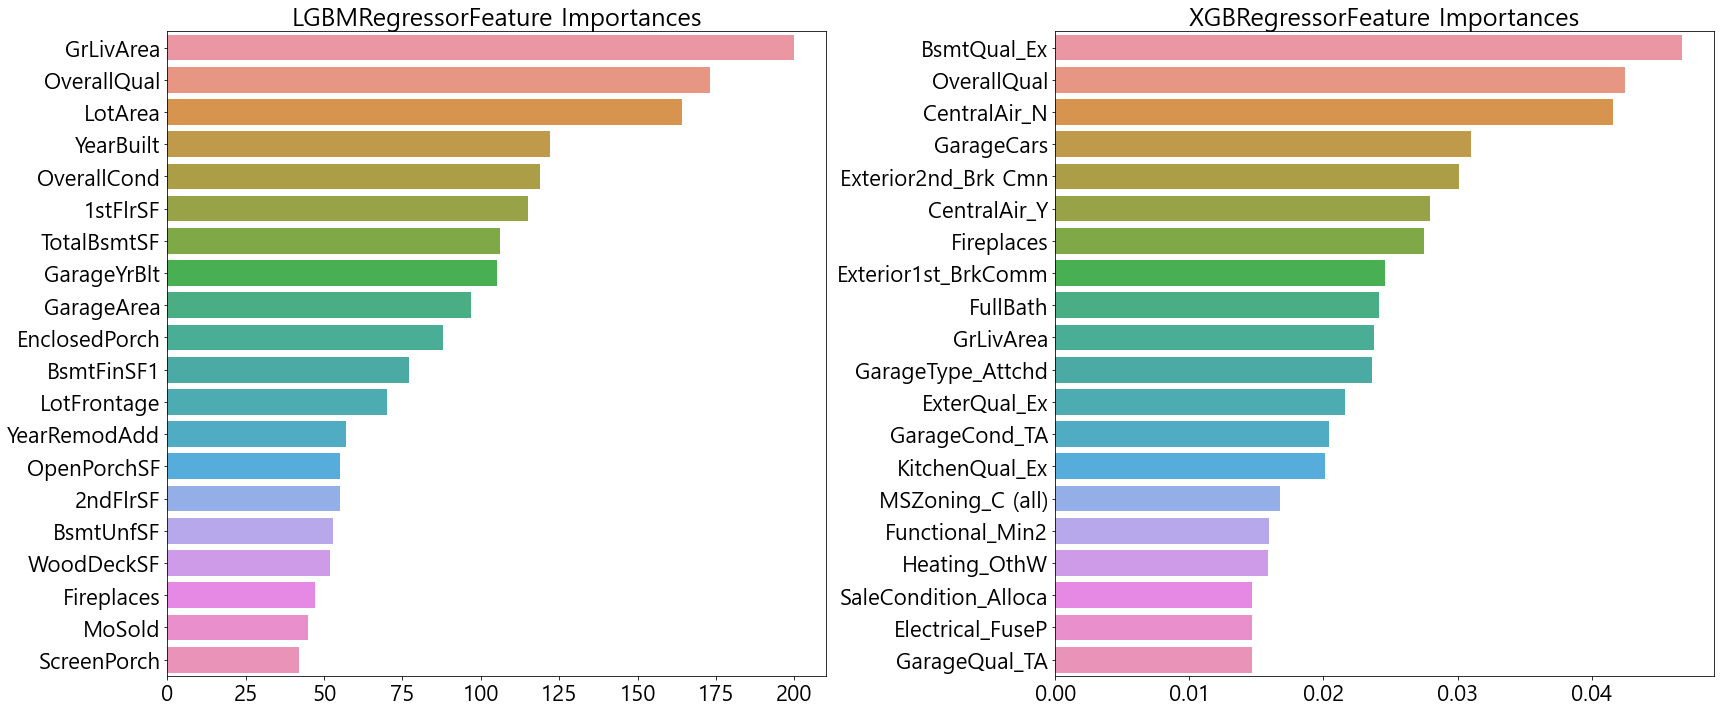

In [38]:
def get_top_feature(model):
    """
    모델의 중요도 상위 20개의 피처명과 그때의 중요도 값을 Series로 반환
    """
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index = X_features.columns)
    ftr_top20 = ftr_importances.sort_values(ascending = False)[:20]
    return ftr_top20

def visualizer_ftr_importances(models):
    """
    2개 회귀모델의 시각화를 위해 2개의 컬럼을 가지는 subplot생성
    """
    fig, axs = plt.subplots(figsize = (24, 10), nrows = 1, ncols = 2)
    fig.tight_layout()
    
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도 값 추출
        ftr_top20 = get_top_feature(model)
        axs[i_num].set_title(model.__class__.__name__+'Feature Importances', size = 25)
        
        # font크기 조정
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x = ftr_top20.values, y = ftr_top20.index, ax = axs[i_num])
    plt.tight_layout()

models = [lgbm, xgb]        
visualizer_ftr_importances(models)

### 회귀모델의 예측 결과 혼합을 통한 최종 예측
* 개별 회귀모델의 예측 결과값을 혼합해 이를 기반으로 최종 회귀 값을 예측

In [39]:
def get_rmse_pred(preds):
    """
    최종 혼합모델, 개별 모델의 RSME값 출력
    """
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print("{0} 모델의 RMSE : {1}".format(key, rmse))

In [40]:
# 개별 모델의 학습
ridge_reg = Ridge(alpha = 8)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha = 0.01)
lasso_reg.fit(X_train, y_train)

# 개별 모델의 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

pred  = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {"최종 혼합": pred,
        "Ridge": ridge_pred,
        "Lasso": lasso_pred}
get_rmse_pred(preds)

최종 혼합 모델의 RMSE : 0.12834526767432464
Ridge 모델의 RMSE : 0.11734286082105315
Lasso 모델의 RMSE : 0.1458686200188069


In [41]:
# XGBoost와 LightGBM을 혼합
xgb_reg = XGBRegressor(n_esitmators = 1000, learning_rate = 0.05, colsample_bytree = 0.5, subsample = 0.8)
lgbm_reg = LGBMRegressor(n_esitmators = 1000, learning_rate = 0.05, num_leaves = 4, subsample = 0.6, colsamplebytree = .4, reg_lambda = 10, n_jobs = -1)

xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {"최종혼합": pred, "XGBM": xgb_pred, "LGBM": lgbm_pred}
get_rmse_pred(preds)

[02:42:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_esitmators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


최종혼합 모델의 RMSE : 0.1393776043344729
XGBM 모델의 RMSE : 0.1462372885598659
LGBM 모델의 RMSE : 0.14885166727368807


**최종 혼합모델의 RMSE가 개별모델보다 향상됨**

### 스태킹 앙상블 모델을 통한 회귀 예측

In [42]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error


def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    """
    개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
    """    
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean  

In [45]:
# get_stacking_base_datasets()는 넘파일 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(base)모델이 생성한 학습용 테스트용 데이터 반환
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n,  5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
[02:44:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_esitmators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


	 폴드 세트:  1  시작 
[02:44:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_esitmators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please

In [46]:
# 개별 모델이 반한한 학습 및 테스트용 데이터세트를 스태킹 형태로 결합
Stack_final_X_train = np.concatenate([ridge_train, lasso_train, xgb_train, lgbm_train], axis = 1)
Stack_final_X_test  = np.concatenate([ridge_test, lasso_test, xgb_test, lgbm_test], axis = 1)

# 최종 메타 모델은 라쏘모델을 적용
meta_model_lasso = Lasso(alpha = 0.0005)

# 개별 모델 예측값을 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측 및 RMSE측정
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print("스태킹 회귀 모델의 최종 RMSE값 : ", rmse)

스태킹 회귀 모델의 최종 RMSE값 :  0.11662838391241212
